In [1]:
# training 8 different models, 4 different numbers of pairs of coordinates in latent space
# trained and applied on original and scaled data

!python ./experiment-machine/train.py --verbose --latent_dim 1 --fitted
!python ./experiment-machine/train.py --verbose --latent_dim 1

!python ./experiment-machine/train.py --verbose --latent_dim 2 --fitted
!python ./experiment-machine/train.py --verbose --latent_dim 2

!python ./experiment-machine/train.py --verbose --latent_dim 3 --fitted
!python ./experiment-machine/train.py --verbose --latent_dim 3

!python ./experiment-machine/train.py --verbose --latent_dim 4 --fitted
!python ./experiment-machine/train.py --verbose --latent_dim 4

Training fitted model:
1 pairs of coords in latent space 
step 0, train_loss 3.0194e+00, test_loss 1.6170e+00
step 200, train_loss 4.7770e-01, test_loss 4.4819e-01
step 400, train_loss 3.3212e-01, test_loss 2.8539e-01
step 600, train_loss 2.6714e-01, test_loss 2.7910e-01
step 800, train_loss 2.7703e-01, test_loss 2.8691e-01
step 1000, train_loss 2.6571e-01, test_loss 2.7689e-01
Final test loss 2.6845e-01 +/- 4.0894e-04
Training noisy model:
1 pairs of coords in latent space 
step 0, train_loss 4.0258e+00, test_loss 1.6595e+00
step 200, train_loss 7.0387e-02, test_loss 1.2859e-01
step 400, train_loss 9.2773e-02, test_loss 8.1347e-02
step 600, train_loss 2.0673e-02, test_loss 1.1038e-02
step 800, train_loss 1.5543e-02, test_loss 1.4809e-02
step 1000, train_loss 2.4249e-02, test_loss 2.5509e-02
Final test loss 2.3100e-02 +/- 2.6117e-04
Training fitted model:
2 pairs of coords in latent space 
step 0, train_loss 2.6978e+00, test_loss 1.3752e+00
step 200, train_loss 1.8133e-01, test_loss 1.

# Task 5: pixel pendulum
Sam Greydanus

In [90]:
import math
import numpy as np
import torch, sys, io
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image, ImageDraw, ImageSequence, ImageFont
import scipy, scipy.misc, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-machine'
sys.path.append(EXPERIMENT_DIR)

from data import get_measurments, hamiltonian_fn, dynamics_fn, get_dataset_clean
from nn_models import MLPAutoencoder, MLP
from hnn import HNN, PixelHNN
from utils import make_gif, L2_loss, integrate_model

## Set some notebook constants

In [91]:
DPI = 300
LINE_SEGMENTS = 20
LINE_WIDTH = 2
FORMAT = 'pdf'

def get_args(latent_cc_pairs):
    return {'input_dim': 8,
         'hidden_dim': 200,
         'latent_dim': latent_cc_pairs,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'print_every': 200,
         'num_frames': 400,
         'name': 'machine-vibration',
         'seed': 0, 
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Load data

In [92]:
t_step=0.001

# load dataset
measurments = np.vstack((np.zeros(8).reshape(1,-1),get_measurments('NORMAL')))
data=torch.tensor(measurments[:-1], dtype=torch.float)
next_data=torch.tensor(measurments[1:], dtype=torch.float)

measurments_dm = np.vstack((np.zeros(8).reshape(1,-1),get_dataset_clean('NORMAL')))
data_dm=torch.tensor(measurments_dm[:-1], dtype=torch.float)
next_data_dm=torch.tensor(measurments_dm[1:], dtype=torch.float)

In [93]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [94]:
# getting positions and velocities

r=1

angle=np.mod(np.cumsum(measurments[:,0] * t_step / 2),1)
tv=angle*r
xv1=np.cumsum(measurments[:,1] * t_step / 2)
yv1=np.cumsum(measurments[:,2] * t_step / 2)
zv1=np.cumsum(measurments[:,3] * t_step / 2)
xv2=np.cumsum(measurments[:,4] * t_step / 2)
yv2=np.cumsum(measurments[:,5] * t_step / 2)
zv2=np.cumsum(measurments[:,6] * t_step / 2)

xq1=np.cumsum(xv1 * t_step / 2)
yq1=np.cumsum(yv1 * t_step / 2)
zq1=np.cumsum(zv1 * t_step / 2)
xq2=np.cumsum(xv2 * t_step / 2)
yq2=np.cumsum(yv2 * t_step / 2)
zq2=np.cumsum(zv2 * t_step / 2)

angle_dm=np.mod(np.cumsum(measurments_dm[:,0] * t_step / 2),1)
tv_dm=angle_dm*r
xv1_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,1] * t_step / 2).reshape(-1, 1))
yv1_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,2] * t_step / 2).reshape(-1, 1))
zv1_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,3] * t_step / 2).reshape(-1, 1))
xv2_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,4] * t_step / 2).reshape(-1, 1))
yv2_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,5] * t_step / 2).reshape(-1, 1))
zv2_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,6] * t_step / 2).reshape(-1, 1))

xq1_dm=np.cumsum(xv1_dm * t_step / 2)
yq1_dm=np.cumsum(yv1_dm * t_step / 2)
zq1_dm=np.cumsum(zv1_dm * t_step / 2)
xq2_dm=np.cumsum(xv2_dm * t_step / 2)
yq2_dm=np.cumsum(yv2_dm * t_step / 2)
zq2_dm=np.cumsum(zv2_dm * t_step / 2)

xq= (xq1 + xq2) / 2
yq= (yq1 + yq2) / 2
zq= (zq1 + zq2) / 2

xv= (xv1 + xv2) / 2
yv= (yv1 + yv2) / 2
zv= (zv1 + zv2) / 2

xq_dm= (xq1_dm + xq2_dm) / 2
yq_dm= (yq1_dm + yq2_dm) / 2
zq_dm= (zq1_dm + zq2_dm) / 2

xv_dm= (xv1_dm + xv2_dm) / 2
yv_dm= (yv1_dm + yv2_dm) / 2
zv_dm= (zv1_dm + zv2_dm) / 2

total_q= ((xq ** 2) + (((measurments[:,0] * r * np.sin(angle * 2 * math.pi)) + yq) ** 2) + (((measurments[:,0] * r * np.cos(angle * 2 * math.pi)) + zq) ** 2)) ** .5
total_q_dm= ((xq_dm ** 2) + (((r * np.sin(angle_dm * 2 * math.pi)) + yq_dm) ** 2) + (((r * np.sin(angle_dm * 2 * math.pi)) + zq_dm) ** 2)) ** .5

total_v= ((xv ** 2) + (((r * np.sin(angle * 2 * math.pi)) + yv) ** 2) + (((r * np.cos(angle * 2 * math.pi)) + zv) ** 2)) ** .5
total_v_dm= ((xv_dm.reshape(1,-1)[0] ** 2) + (((measurments_dm[:,0] * r * np.sin(angle_dm * 2 * math.pi)) + yv_dm.reshape(1,-1)[0]) ** 2) + (((measurments_dm[:,0] * r * np.sin(angle_dm * 2 * math.pi)) + zv_dm.reshape(1,-1)[0]) ** 2)) ** .5

## Visualize data

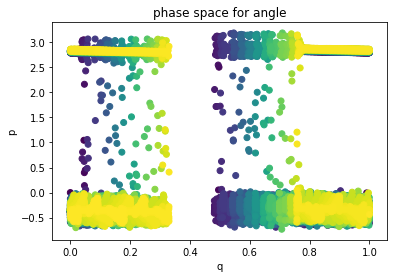

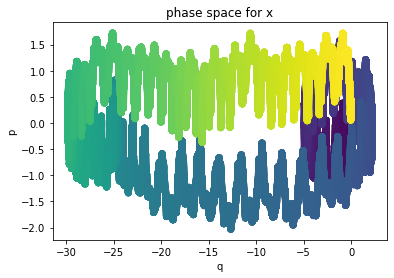

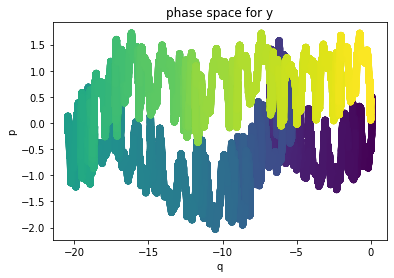

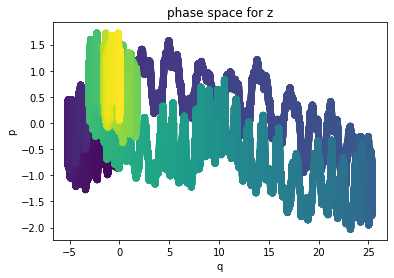

In [95]:
# true phase space of scaled measurements, color is just time progression. 
# For linear movement in the x,y, and z directions, there appears to be a closed orbit but it is very noisy

plt.scatter(angle_dm, measurments_dm[:,0], c=range(250000))
plt.title('phase space for angle')
plt.xlabel('q')
plt.ylabel('p')
plt.show()
plt.close()

plt.scatter(xq_dm, xv_dm, c=range(250000))
plt.title('phase space for x')
plt.xlabel('q')
plt.ylabel('p')
plt.show()
plt.close()

plt.scatter(yq_dm, xv_dm, c=range(250000))
plt.title('phase space for y')
plt.xlabel('q')
plt.ylabel('p')
plt.show()
plt.close()

plt.scatter(zq_dm, xv_dm, c=range(250000))
plt.title('phase space for z')
plt.xlabel('q')
plt.ylabel('p')
plt.show()
plt.close()

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


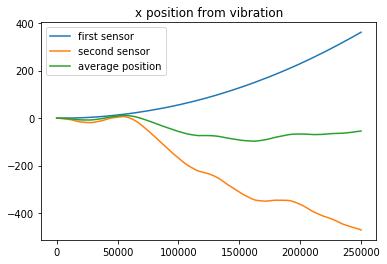

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


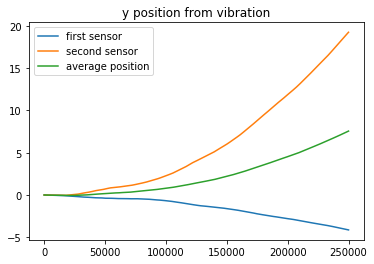

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


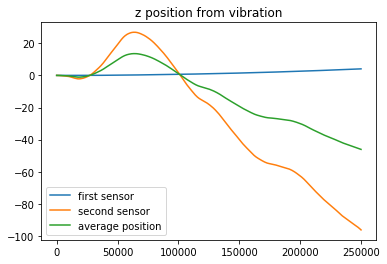

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


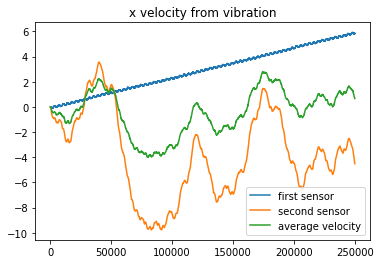

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


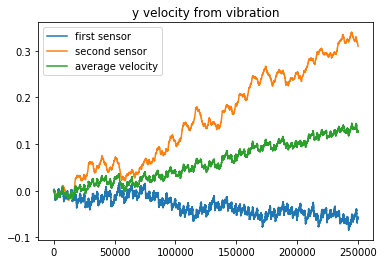

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


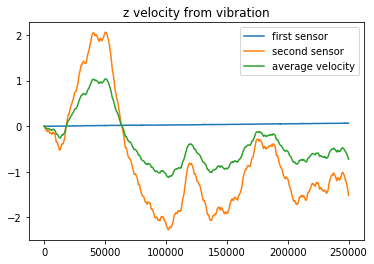

In [96]:
# just to see the untampered positions and velocities

plt.plot(xq1, label='first sensor')
plt.plot(xq2, label='second sensor')
plt.plot(xq, label='average position')
plt.title('x position from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(yq1, label='first sensor')
plt.plot(yq2, label='second sensor')
plt.plot(yq, label='average position')
plt.title('y position from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(zq1, label='first sensor')
plt.plot(zq2, label='second sensor')
plt.plot(zq, label='average position')
plt.title('z position from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(xv1, label='first sensor')
plt.plot(xv2, label='second sensor')
plt.plot(xv, label='average velocity')
plt.title('x velocity from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(yv1, label='first sensor')
plt.plot(yv2, label='second sensor')
plt.plot(yv, label='average velocity')
plt.title('y velocity from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(zv1, label='first sensor')
plt.plot(zv2, label='second sensor')
plt.plot(zv, label='average velocity')
plt.title('z velocity from vibration')
plt.legend()
plt.show()
plt.close()

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


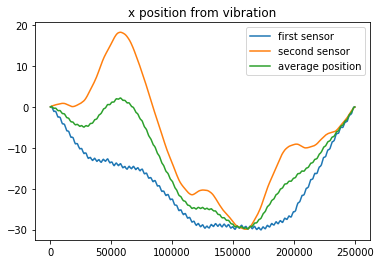

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


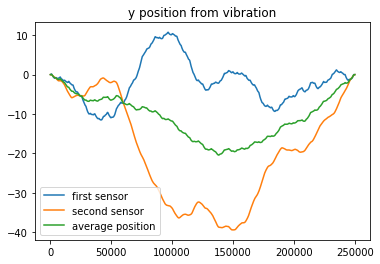

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


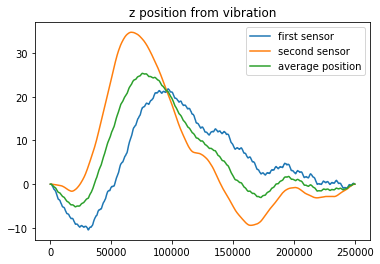

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


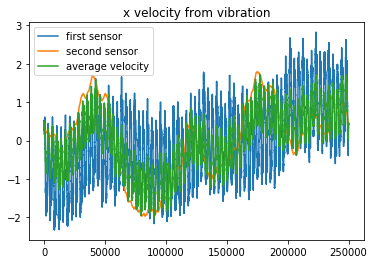

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


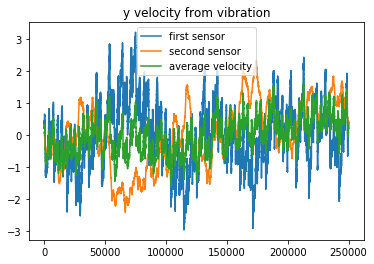

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


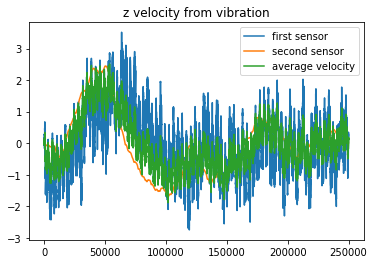

In [97]:
#just to see the velocities and positions of scaled data

plt.plot(xq1_dm, label='first sensor')
plt.plot(xq2_dm, label='second sensor')
plt.plot(xq_dm, label='average position')
plt.title('x position from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(yq1_dm, label='first sensor')
plt.plot(yq2_dm, label='second sensor')
plt.plot(yq_dm, label='average position')
plt.title('y position from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(zq1_dm, label='first sensor')
plt.plot(zq2_dm, label='second sensor')
plt.plot(zq_dm, label='average position')
plt.title('z position from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(xv1_dm, label='first sensor')
plt.plot(xv2_dm, label='second sensor')
plt.plot(xv_dm, label='average velocity')
plt.title('x velocity from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(yv1_dm, label='first sensor')
plt.plot(yv2_dm, label='second sensor')
plt.plot(yv_dm, label='average velocity')
plt.title('y velocity from vibration')
plt.legend()
plt.show()
plt.close()

plt.plot(zv1_dm, label='first sensor')
plt.plot(zv2_dm, label='second sensor')
plt.plot(zv_dm, label='average velocity')
plt.title('z velocity from vibration')
plt.legend()
plt.show()
plt.close()

## Construct models

In [98]:
def load_model(args, fixed=True):
    autoencoder = MLPAutoencoder(args.input_dim, args.hidden_dim,
                                     args.latent_dim * 2, nonlinearity='relu')
    model = PixelHNN(args.latent_dim * 2, args.hidden_dim, autoencoder,
                     nonlinearity=args.nonlinearity)
    demean = '-demeaned' if fixed else '-noisy'
    path = "{}/vibration_machine-{}-pairs{}.tar".format(args.save_dir, args.latent_dim,demean)
    model.load_state_dict(torch.load(path))
    return model

In [99]:
#loading models

args1 = ObjectView(get_args(1))
clean_model1 = load_model(args1, fixed=True)
noisy_model1 = load_model(args1, fixed=False)

args2 = ObjectView(get_args(2))
clean_model2 = load_model(args2, fixed=True)
noisy_model2 = load_model(args2, fixed=False)

args3 = ObjectView(get_args(3))
clean_model3 = load_model(args3, fixed=True)
noisy_model3 = load_model(args3, fixed=False)

args4 = ObjectView(get_args(4))
clean_model4 = load_model(args4, fixed=True)
noisy_model4 = load_model(args4, fixed=False)

In [100]:
#splitting the data based on angular velocity

above4=data[data[:,0]>=4, :]
below0=data[data[:,0]<=0, :]

above2_dm=data_dm[data_dm[:,0]>=2, :]
below0_dm=data_dm[data_dm[:,0]<=0, :]

In [101]:
def integrate_model1(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1, 2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_model2(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1, 4)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_model3(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1, 6)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_model4(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1, 8)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [109]:
def integrate_models():
    np.random.seed(0)
    t_span = [0,500]
    kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2500), 'rtol': 1e-12}

    # integrate 2 dimensions original w noise
    x1_path = integrate_model1(noisy_model1, t_span, np.random.rand(2), **kwargs)
    x1pair = x1_path['y'].T
    
    # integrate 4 dimensions original w noise
    x2_path = integrate_model2(noisy_model2, t_span, np.random.rand(4), **kwargs)
    x2pair = x2_path['y'].T

    # integrate 6 dimensions original w noise
    x3_path = integrate_model3(noisy_model3, t_span, np.random.rand(6), **kwargs)
    x3pair = x3_path['y'].T

    # integrate 8 dimensions original w noise
    x4_path = integrate_model4(noisy_model4, t_span, np.random.rand(8), **kwargs)
    x4pair = x4_path['y'].T
    
    # integrate 2 dimensions scaled
    x1_path_clean = integrate_model1(clean_model1, t_span, np.random.rand(2), **kwargs)
    x1pair_clean = x1_path_clean['y'].T
    
    # integrate 4 dimensions scaled
    x2_path_clean = integrate_model2(clean_model2, t_span, np.random.rand(4), **kwargs)
    x2pair_clean = x2_path_clean['y'].T

    # integrate 6 dimensions scaled
    x3_path_clean = integrate_model3(clean_model3, t_span, np.random.rand(6), **kwargs)
    x3pair_clean = x3_path_clean['y'].T

    # integrate 8 dimensions scaled
    x4_path_clean = integrate_model4(clean_model4, t_span, np.random.rand(8), **kwargs)
    x4pair_clean = x4_path_clean['y'].T

    return x1pair, x2pair, x3pair, x4pair,  x1pair_clean, x2pair_clean, x3pair_clean, x4pair_clean

x1pair, x2pair, x3pair, x4pair,  x1pair_clean, x2pair_clean, x3pair_clean, x4pair_clean=integrate_models()

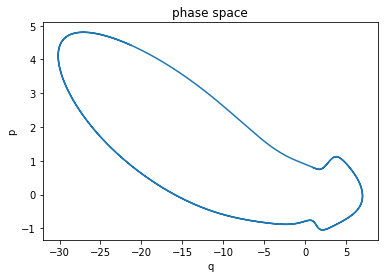

In [110]:
# a phase space trajectory in 2 dimensions on the scaled data

plt.plot(x1pair_clean[:,0], x1pair_clean[:,1])
plt.title('phase space')
plt.xlabel('q')
plt.ylabel('p')
plt.show()
plt.close()

In [104]:
true_pq=np.vstack((total_q,total_v)).reshape(-1,2)
true_pq_dm=np.vstack((total_q_dm,total_v_dm)).reshape(-1,2)

encode_pq1=clean_model1.encode(torch.tensor(measurments, dtype=torch.float)).detach().numpy()
encode_pq_dm1=noisy_model1.encode(torch.tensor(measurments_dm, dtype=torch.float)).detach().numpy()

encode_pq2=clean_model2.encode(torch.tensor(measurments, dtype=torch.float)).detach().numpy()
encode_pq_dm2=noisy_model2.encode(torch.tensor(measurments_dm, dtype=torch.float)).detach().numpy()

encode_pq3=clean_model3.encode(torch.tensor(measurments, dtype=torch.float)).detach().numpy()
encode_pq_dm3=noisy_model3.encode(torch.tensor(measurments_dm, dtype=torch.float)).detach().numpy()

encode_pq4=clean_model4.encode(torch.tensor(measurments, dtype=torch.float)).detach().numpy()
encode_pq_dm4=noisy_model4.encode(torch.tensor(measurments_dm, dtype=torch.float)).detach().numpy()

In [105]:
hamiltonian1=np.sum(hamiltonian_fn(encode_pq1), axis = 1, keepdims = True)
hamiltonian2=np.sum(hamiltonian_fn(encode_pq2), axis = 1, keepdims = True) 
hamiltonian3=np.sum(hamiltonian_fn(encode_pq3), axis = 1, keepdims = True) 
hamiltonian4=np.sum(hamiltonian_fn(encode_pq4), axis = 1, keepdims = True) 

hamiltonian1_dm=np.sum(hamiltonian_fn(encode_pq_dm1), axis = 1, keepdims = True)
hamiltonian2_dm=np.sum(hamiltonian_fn(encode_pq_dm2), axis = 1, keepdims = True) 
hamiltonian3_dm=np.sum(hamiltonian_fn(encode_pq_dm3), axis = 1, keepdims = True) 
hamiltonian4_dm=np.sum(hamiltonian_fn(encode_pq_dm4), axis = 1, keepdims = True) 

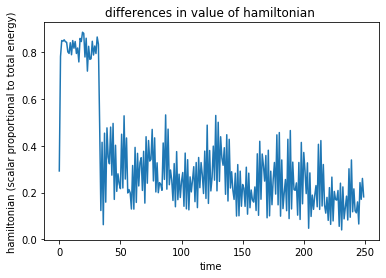

In [106]:
# The model discerns between high angular velocity (higher hamiltonian value) and low velocity (lower hamiltonian value/)

plt.plot(hamiltonian1_dm[:250])
plt.title('differences in value of hamiltonian ')
plt.xlabel('time')
plt.ylabel('hamiltonian (scalar proportional to total energy)')
plt.show()

In [107]:
a4n1=noisy_model1.encode(above4).detach().numpy()
b0n1=noisy_model1.encode(below0).detach().numpy()
a2c1=clean_model1.encode(above2_dm).detach().numpy()
b0c1=clean_model1.encode(below0_dm).detach().numpy()

a4n2=noisy_model2.encode(above4).detach().numpy()
b0n2=noisy_model2.encode(below0).detach().numpy()
a2c2=clean_model2.encode(above2_dm).detach().numpy()
b0c2=clean_model2.encode(below0_dm).detach().numpy()

a4n3=noisy_model3.encode(above4).detach().numpy()
b0n3=noisy_model3.encode(below0).detach().numpy()
a2c3=clean_model3.encode(above2_dm).detach().numpy()
b0c3=clean_model3.encode(below0_dm).detach().numpy()

a4n4=noisy_model4.encode(above4).detach().numpy()
b0n4=noisy_model4.encode(below0).detach().numpy()
a2c4=clean_model4.encode(above2_dm).detach().numpy()
b0c4=clean_model4.encode(below0_dm).detach().numpy()

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


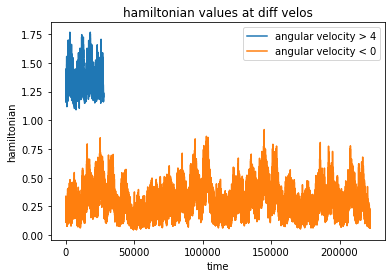

In [108]:
# model does indeed learn a total energy

a4h1=np.sum(hamiltonian_fn(a4n1), axis = 1, keepdims = True)
b0h1=np.sum(hamiltonian_fn(b0n1), axis = 1, keepdims = True)

plt.plot(a4h1, label='angular velocity > 4')
plt.plot(b0h1, label='angular velocity < 0')
plt.title('hamiltonian values at diff velos')
plt.ylabel('hamiltonian')
plt.xlabel('time')
plt.legend()
plt.show()